In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pprint import pprint
import pickle
import time
import datetime

In [2]:
# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
# from qiskit.tools.monitor import job_monitor
from qiskit.compiler import transpile
from qiskit.transpiler.passes import RemoveBarriers

In [3]:
# Import state tomography modules
from qiskit_experiments.library import StateTomography
from osp_solutions.patch_ignis import rename_qcs_StateTomography_to_ignis
from osp_solutions.tomography import StateTomographyFitter
from qiskit.quantum_info import state_fidelity

In [4]:
from osp_solutions.circuits_initial import gate_initial_state
from osp_solutions.circuits_path import gate_path_proposed, gate_path_conventional
from osp_solutions.simulator_dm import make_dm_binary, hamiltonian_to_dm, DMExtended
from osp_solutions.hamiltonian import Hamiltonian, make_H_Heisenberg_path
from osp_solutions.backend_simulator import result_to_dms
from setting import *

NoiseModel:
  Basis gates: ['cx', 'cz', 'h', 'id', 'rx', 'rz', 's', 'sdg', 'sx', 'u1', 'u2', 'u3', 'x']
  Instructions with noise: ['u1', 'sdg', 'cz', 'u2', 'h', 'u3', 'rz', 'rx', 'sx', 'x', 's', 'cx']
  All-qubits errors: ['rx', 'rz', 'sx', 'h', 'sdg', 's', 'x', 'u1', 'u2', 'u3', 'cx', 'cz']



In [5]:
dt = Parameter('t')
state_initial_dm = DMExtended(matrix=make_dm_binary(str_binary=state_initial,
                                                    endian_binary="big",
                                                    endian_dm="little")) ### make the density matrix for the initial state

H_Heisenberg = make_H_Heisenberg_path(num_qubits=num_qubits) ### create Heisenberg Hamiltonian in a dictionary format
matrix_Heisenberg = hamiltonian_to_dm(hamiltonian=H_Heisenberg) ### convert Heisenberg Hamiltonian to its matrix form

U_Heisenberg = DMExtended(sp.linalg.expm(-1.0j * matrix_Heisenberg * time_evolution)) ### prepare the unitary matrix of the Heisenberg Hamiltonian

state_target_dm = state_initial_dm.apply_unitary(U_Heisenberg) ### apply the unitary evolution to the density matrix
state_target_dm.is_valid()

True

In [6]:
fidelities = []
nums_cnots = []

print("trotter step list: ", num_steps_list)
for num_steps in num_steps_list:
    
    print("trotter steps: ", num_steps)
    t1 = time.perf_counter()
    
    # Initialize quantum circuit for 3 qubits
    qc = QuantumCircuit(num_qubits)

    # Prepare initial state
    qc.compose(gate_initial_state(state_initial=state_initial),
               qubits=list(range(num_qubits)),
               inplace=True,)
    
    qc.append(instruction=gate_path_proposed(num_qubits=num_qubits,
                                             num_steps=num_steps // 2, ###!
                                             dt=dt * 2, ###!
                                             type_H_eff=type_H_eff,
                                             to_instruction=False,
                                             add_barrier=False,
                                          ),
              qargs=list(range(num_qubits)),
             )

    # Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
    qc = qc.assign_parameters({dt: time_evolution / num_steps})
    qc_t3 = transpile(RemoveBarriers()(qc), optimization_level=3, basis_gates=["sx", "cx", "rz"])
    qc_t3.save_density_matrix()
    
    ### execute circuits
    result_raw = simulator_ideal.run(qc_t3,
                                     shots=0,
                                    ).result()
    dm_raw = result_to_dms(result=result_raw,
                           endian_result="little",
                           endian_dm="little",
                          )[0]

    fidelities.append(state_fidelity(dm_raw, state_target_dm))
    nums_cnots.append(qc_t3.count_ops().get("cx"))
    
    t2 = time.perf_counter()
    print("raw state tomography fidelity = {:.4f}".format(fidelities[-1]))
    print("number of CNOT gates:", qc_t3.count_ops().get("cx"))
    print("time:", t2 - t1)
    print()

trotter step list:  [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96]
trotter steps:  4
raw state tomography fidelity = 0.0385
number of CNOT gates: None
time: 0.36843483289703727

trotter steps:  8
raw state tomography fidelity = 0.0721
number of CNOT gates: 112
time: 0.4880833341740072

trotter steps:  12
raw state tomography fidelity = 0.0220
number of CNOT gates: 168
time: 0.590141458902508

trotter steps:  16
raw state tomography fidelity = 0.0621
number of CNOT gates: 224
time: 0.5888668750412762

trotter steps:  20
raw state tomography fidelity = 0.2722
number of CNOT gates: 280
time: 0.640812624944374

trotter steps:  24
raw state tomography fidelity = 0.4809
number of CNOT gates: 336
time: 0.6519061250146478

trotter steps:  28
raw state tomography fidelity = 0.6294
number of CNOT gates: 392
time: 0.7012157081626356

trotter steps:  32
raw state tomography fidelity = 0.7283
number of CNOT gates: 448
time: 0.7324919169768691

trotter

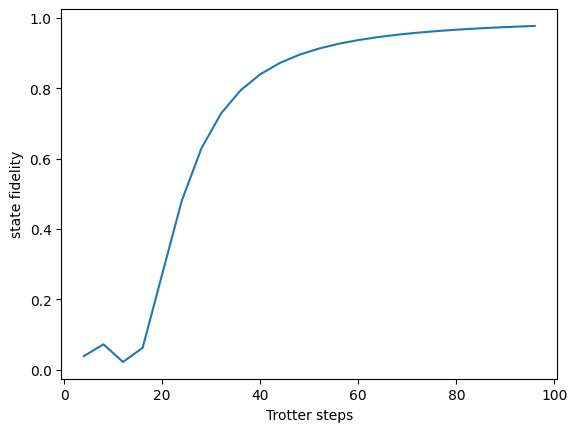

In [7]:
plt.plot(num_steps_list, fidelities)
plt.xlabel("Trotter steps")
plt.ylabel("state fidelity")
plt.show()

In [8]:
with open("run_proposed.pkl", "wb") as f:
    pickle.dump(obj={"num_steps_list": num_steps_list, 
                     "fidelities": fidelities, 
                     "nums_cnots": nums_cnots},
                file=f)

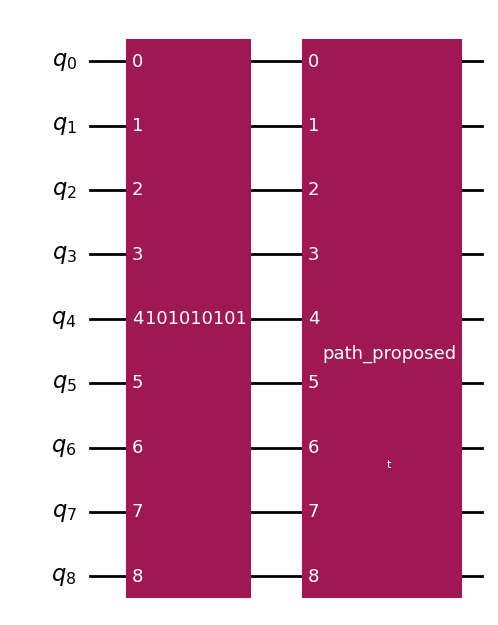

In [9]:
qc = QuantumCircuit(num_qubits)
qc.compose(gate_initial_state(state_initial=state_initial),
            qubits=list(range(num_qubits)),
            inplace=True,)

qc.append(instruction=gate_path_proposed(num_qubits=num_qubits,
                                            num_steps=2, ###!
                                            dt=dt,
                                            type_H_eff=type_H_eff,
                                            to_instruction=False,
                                            add_barrier=False,
                                        ),
            qargs=list(range(num_qubits)),
            )
qc.draw("mpl")

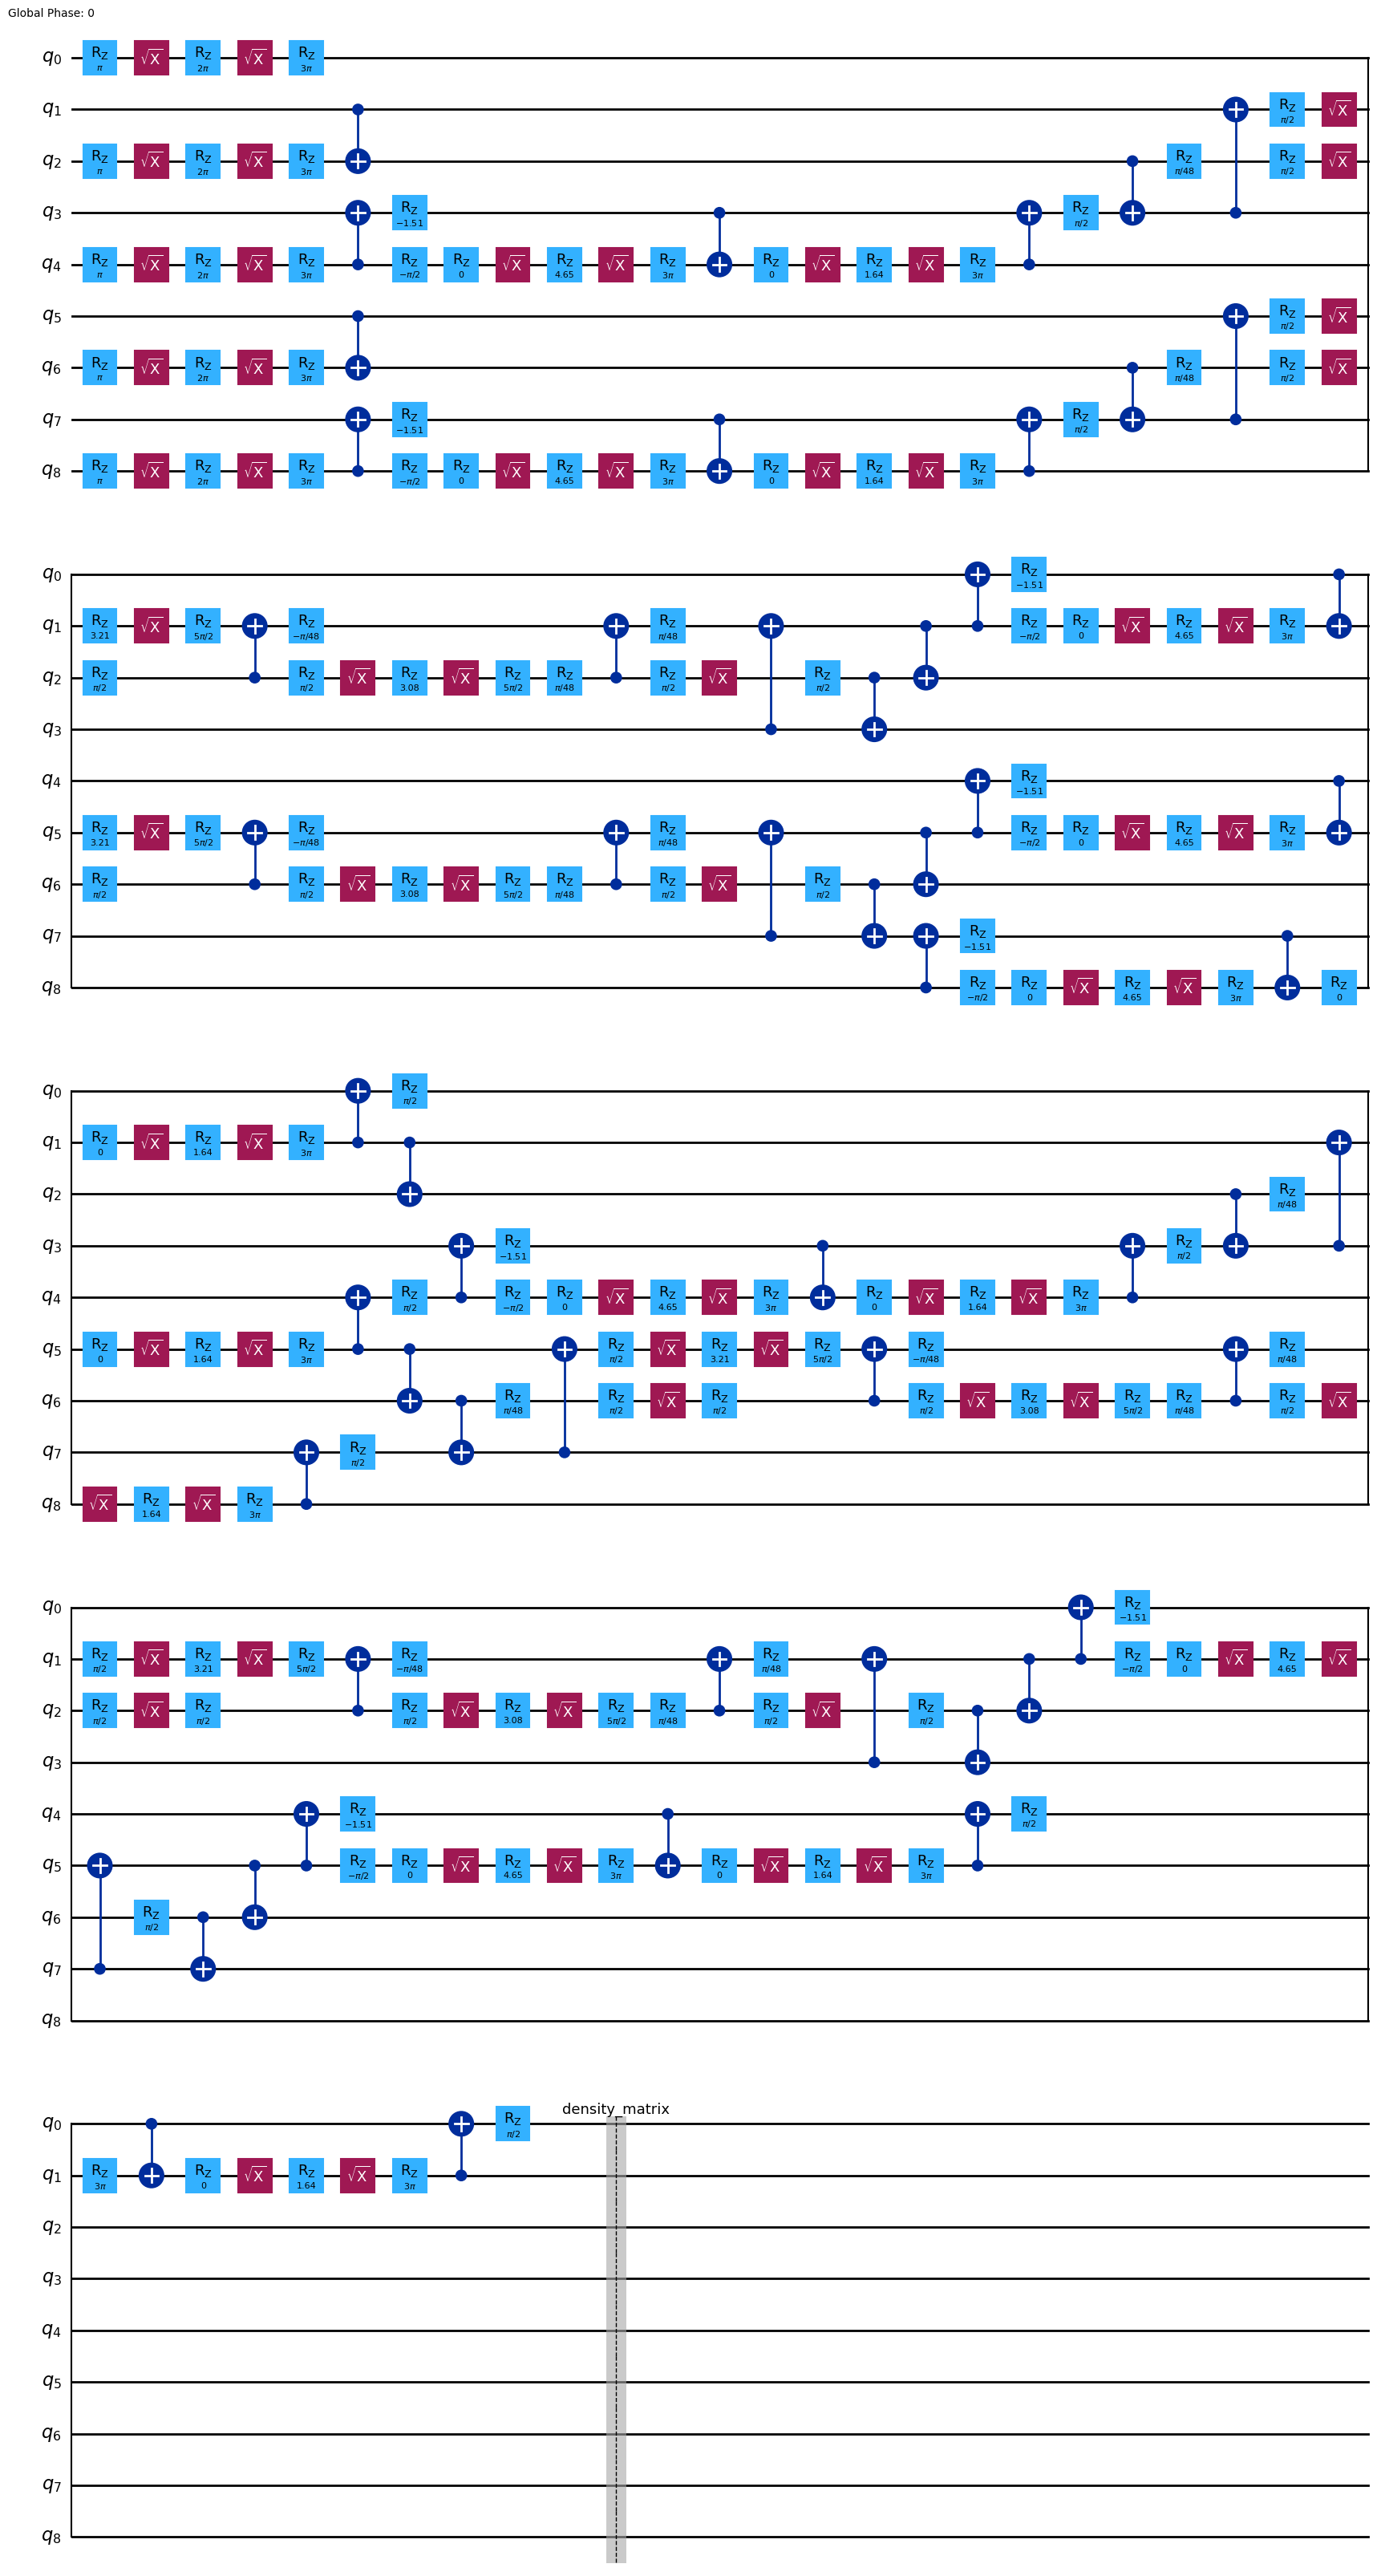

In [10]:
qc = QuantumCircuit(num_qubits)

# Prepare initial state
qc.compose(gate_initial_state(state_initial=state_initial),
            qubits=list(range(num_qubits)),
            inplace=True,)

qc.append(instruction=gate_path_proposed(num_qubits=num_qubits,
                                            num_steps=2, ###!
                                            dt=dt,
                                            type_H_eff=type_H_eff,
                                            to_instruction=False,
                                            add_barrier=False,
                                        ),
            qargs=list(range(num_qubits)),
            )

# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
qc = qc.assign_parameters({dt: time_evolution / num_steps})
# qc_t3 = transpile(RemoveBarriers()(qc), optimization_level=3, basis_gates=["sx", "cx", "rz"])
qc_t3 = transpile(qc, optimization_level=0, basis_gates=["sx", "cx", "rz"])
qc_t3.save_density_matrix()
qc_t3.draw("mpl")